# Feature Extraction

In [27]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
import dataset



In [28]:
def visualize_images(images, png=True):
    # Give this function any number of images or depth maps
    # and it will display them in a grid.

    if not png:
        images = [np.transpose(img, (1, 2, 0)) for img in images]
    n = len(images)
    # Calculate number of rows and columns
    width = math.ceil(math.sqrt(n))
    height = math.ceil(n / width)
    plt.figure(figsize=(17.5, 5))
    fig, axes = plt.subplots(height, width)
    plt.subplots_adjust(wspace=0, hspace=0)
    if n == 1:
        axes.imshow(images[0])
        axes.axis('off')
        return
    for i, ax in enumerate(axes.flatten()):
        if(i<n): 
            # Display image
            image = images[i]
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide axis if no image
            ax.axis('off')
    fig.set_size_inches(17.454545*width, 5*height)
    plt.show()

def visualize_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def load_image(file_path):
    return Image.open(file_path)

def load_depth(file_path):
    return Image.open(file_path)

class MinMaxNormalize(object):
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
class DivBy255(object):
    def __call__(self, tensor):
        return tensor / 255

<Figure size 1750x500 with 0 Axes>

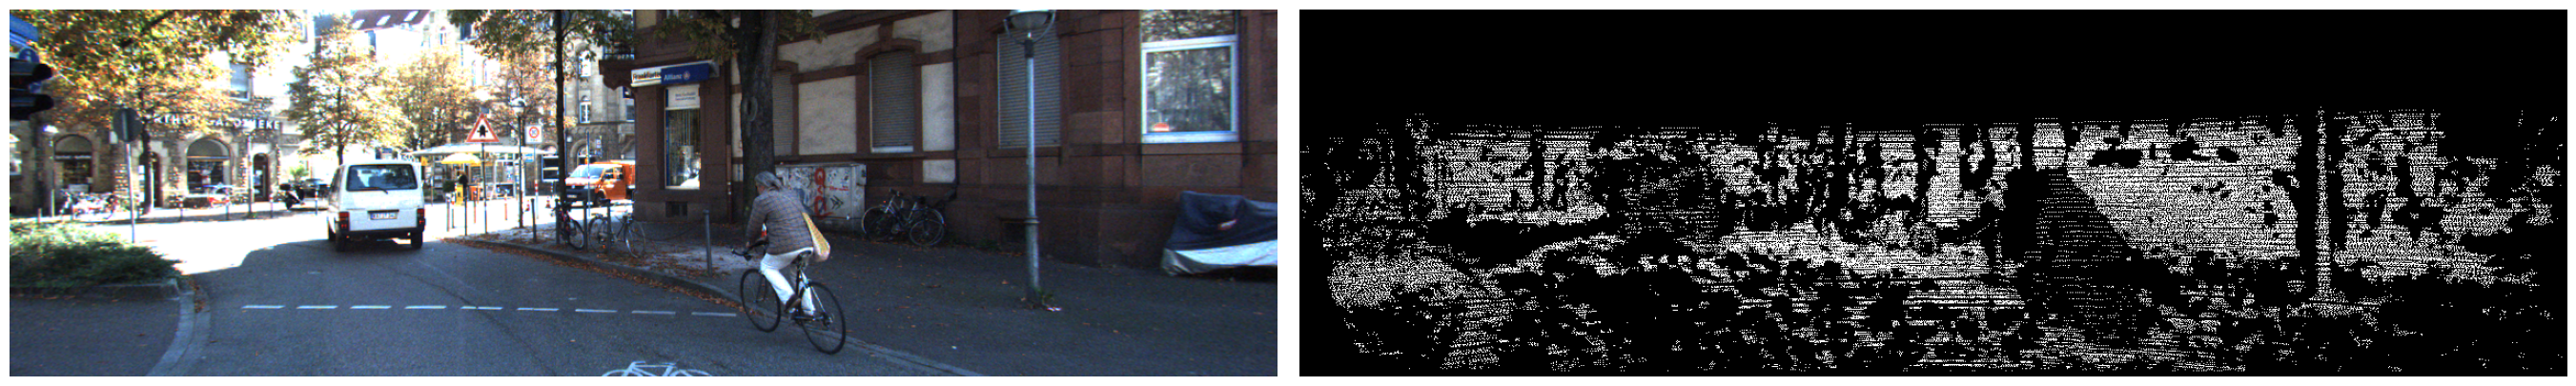

In [29]:
# Set Directories
base_dir = 'dataset'
image_dir = os.path.join(base_dir, 'image')
depth_dir = os.path.join(base_dir, 'groundtruth_depth')

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
depth_files = sorted([os.path.join(depth_dir, file) for file in os.listdir(depth_dir)])

# Ensure that the lists are aligned and have the same length
assert len(image_files) == len(depth_files), "The number of images and depth maps should be the same"

# Load the data into variables
images = [load_image(file) for file in image_files]
depth_maps = [load_depth(file) for file in depth_files]
data = list(zip(images, depth_maps))

# Visualize a sample from the dataset
visualize_images([images[30], depth_maps[30]])

In [30]:
def display_two_images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots
    
    # Display the first image on the left subplot
    axes[0].imshow(image1)
    # axes[0].set_title('Image 1')
    
    # Display the second image on the right subplot
    axes[1].imshow(image2)
    # axes[1].set_title('Image 2')
    
    # Hide axis ticks and labels for better visualization
    for ax in axes:
        ax.axis('off')
    
    plt.show()

<Figure size 1750x500 with 0 Axes>

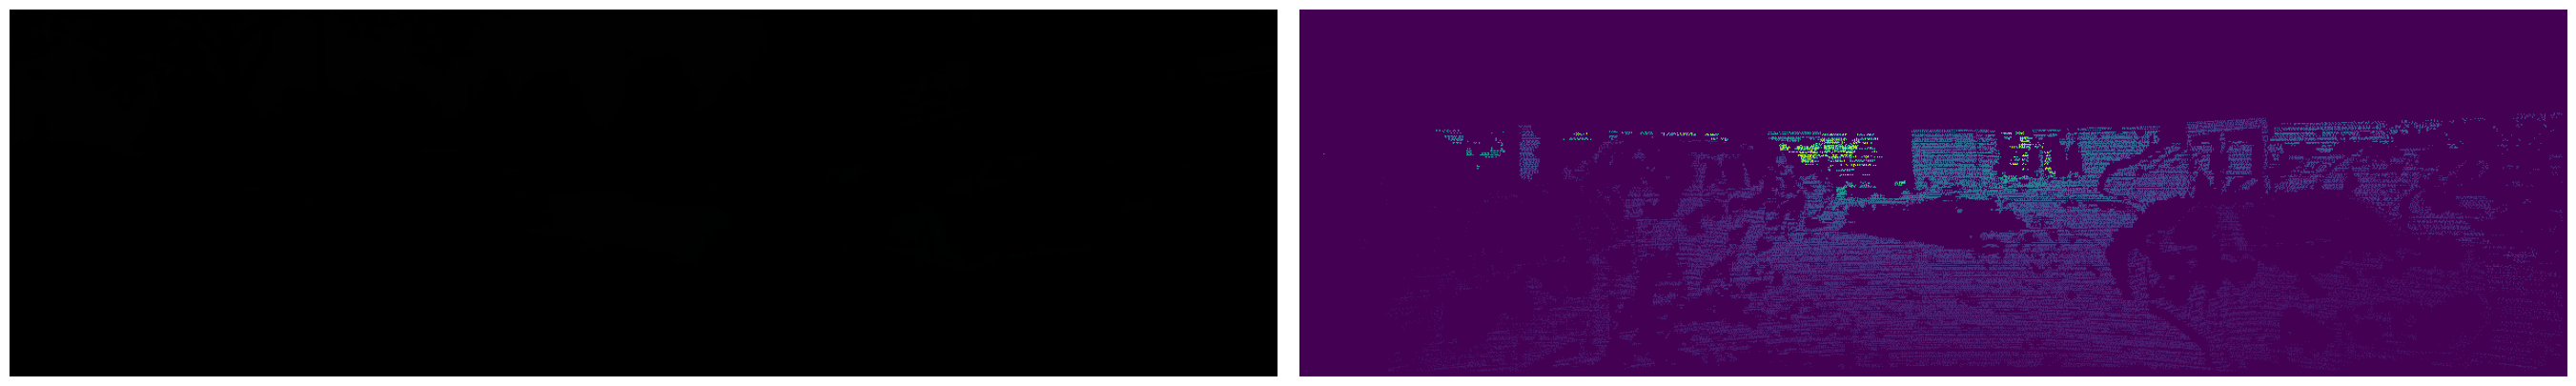

<Figure size 1750x500 with 0 Axes>

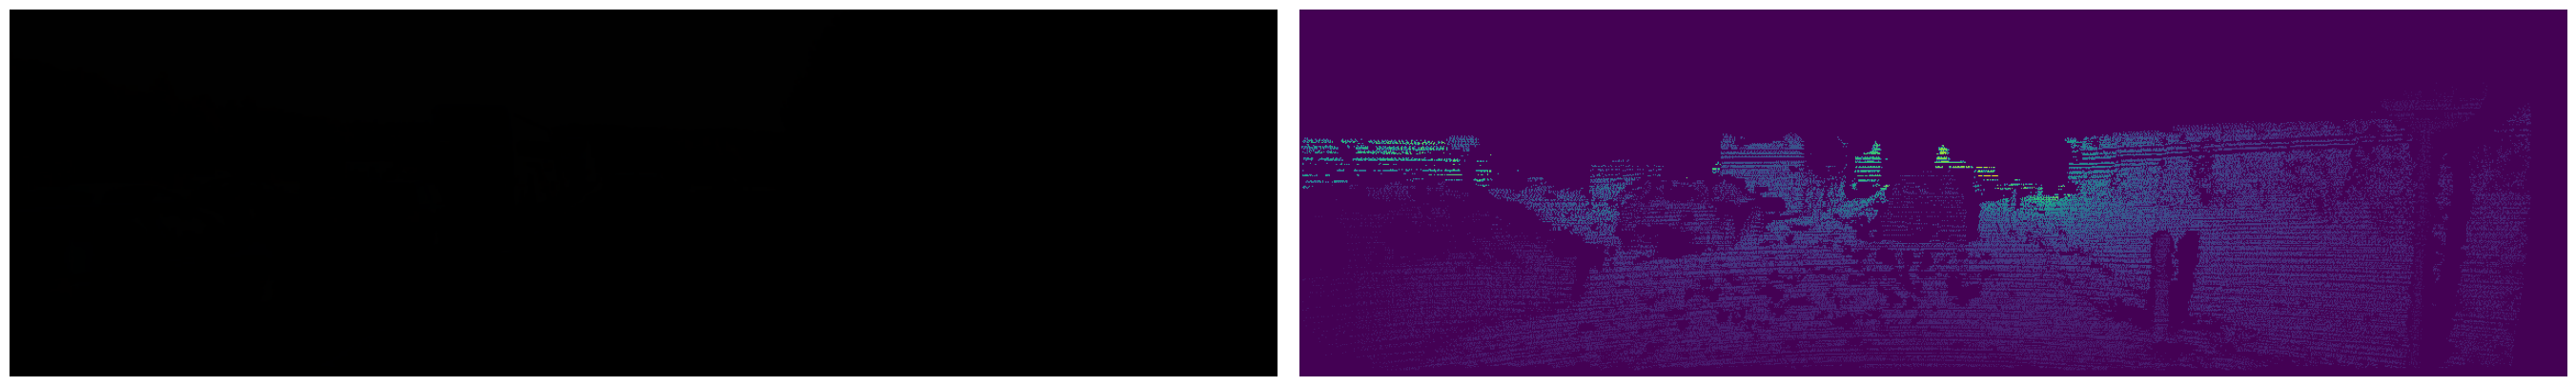

<Figure size 1750x500 with 0 Axes>

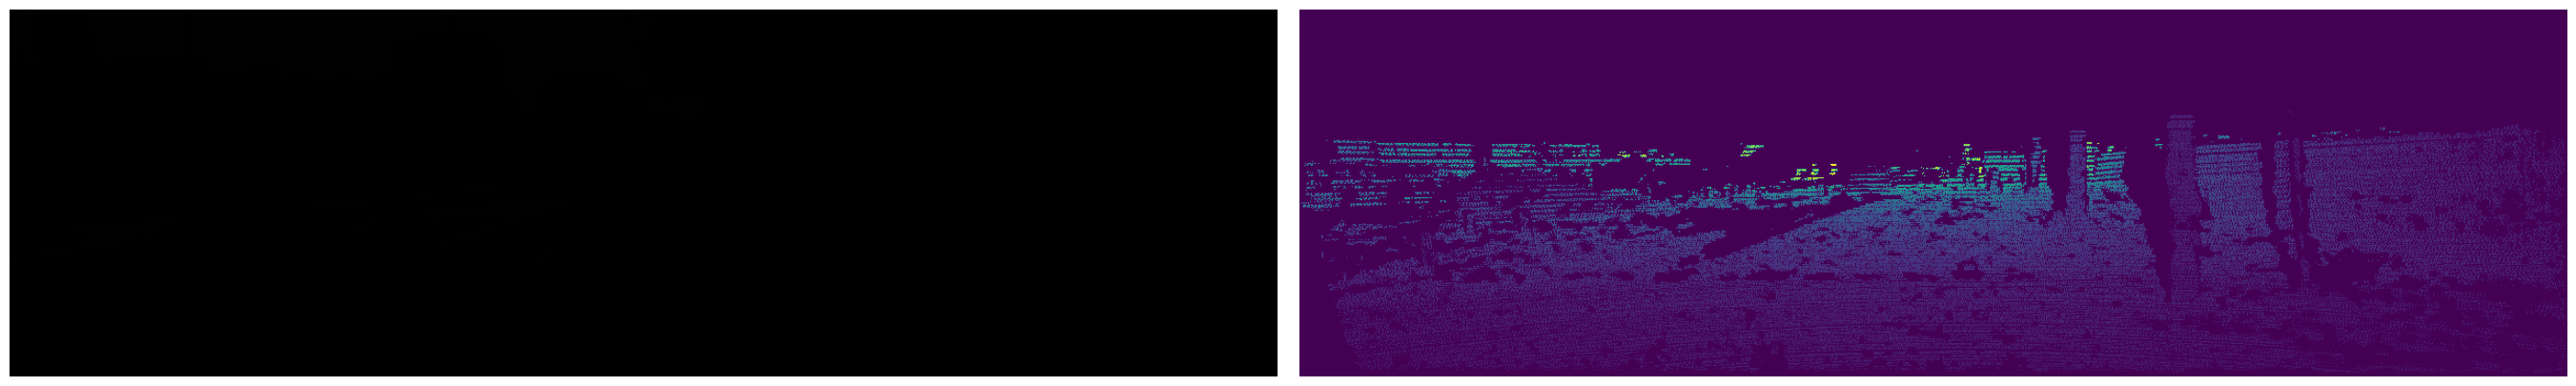

In [31]:
# define image transformation
transform = transforms.Compose([
    transforms.Resize((352, 1216)),
    transforms.ToTensor(),
    DivBy255()
])

train, test = train_test_split(data, test_size=0.20, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)

train_dataset = dataset.DepthDataset(train, transform)
val_dataset = dataset.DepthDataset(val, transform)
test_dataset = dataset.DepthDataset(test, transform)

batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# dataiter = iter(trainloader)
# images_batch1, labels_batch1 = next(dataiter)

# # Print the first two examples
# image1 = np.transpose(images_batch1[0], (1, 2, 0))
# image2 = np.transpose(labels_batch1[0], (1, 2, 0))
# visualize_images([image1, image2], png=False)

# Print the first two train, val, and test examples
dataiter = iter(trainloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)
dataiter = iter(valloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)
dataiter = iter(testloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)


In [32]:
# def load_model(removed_layers = 1):
#     # Load Pre-Trained Model
#     model = models.resnet18(pretrained=True)
#     #model = model.to("cpu")
#     #remove final connected layers from model
#     #model.fc = nn.Identity()
#     model = torch.nn.Sequential(*list(model.children())[:-removed_layers])
#     return model

# # Function to extract features
# def extract_features(dataloader, model = load_model(1)):
#     features = []
#     with torch.no_grad(): #Disables gradient calcullation
#         for inputs, _ in dataloader:
#             outputs = model(inputs)
#             features.append(outputs.flatten(1))
#     return torch.cat(features)

# features = extract_features(trainloader, load_model(1))
# features.shape

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DenseNetAutoencoder(nn.Module):
    def __init__(self, remove=2, pretrained=True):
        super(DenseNetAutoencoder, self).__init__()

        # Load pre-trained DenseNet-121 model
        densenet = models.densenet121(pretrained=pretrained)

        # Extract layers up to the final convolutional layer (before the fully connected layers)
        self.encoder = nn.Sequential(*list(densenet.features.children())[:-remove])

        # Decoder layers: Upsampling and convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # UP1
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),   # UP2
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),     # UP3
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        print(f"Shape of input: {x.shape}")
        x = self.encoder(x)
        print(f"Shape of latent representation: {x.shape}")
        x = self.decoder(x)
        print(f"Shape after decoding: {x.shape}")
        return x

class ResNet18Autoencoder(nn.Module):
    def __init__(self, remove=2, pretrained=True):
        super(ResNet18Autoencoder, self).__init__()
        
        # Load pre-trained ResNet-18 model
        resnet = models.resnet18(weights=pretrained)
        
        # Extract layers up to the final convolutional layer (before the fully connected layers)
        self.encoder = nn.Sequential(*list(resnet.children())[:-remove])

        # Decoder layers: Upsampling and convolutional layers
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 2x2 bilinear upsampling
            nn.ConvTranspose2d(64, 1, kernel_size=1, stride=1, padding=0),

            # nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # Upsample
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # Upsample
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        # print(f"Shape of input: {x.shape}")
        x = self.encoder(x)
        # print(f"Shape of latent representation: {x.shape}")
        x = self.decoder(x)
        # print(f"Shape after decoding: {x.shape}")
        return x

C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/85 [00:00<?, ?it/s]

loss: 2.944244384765625


<Figure size 1750x500 with 0 Axes>

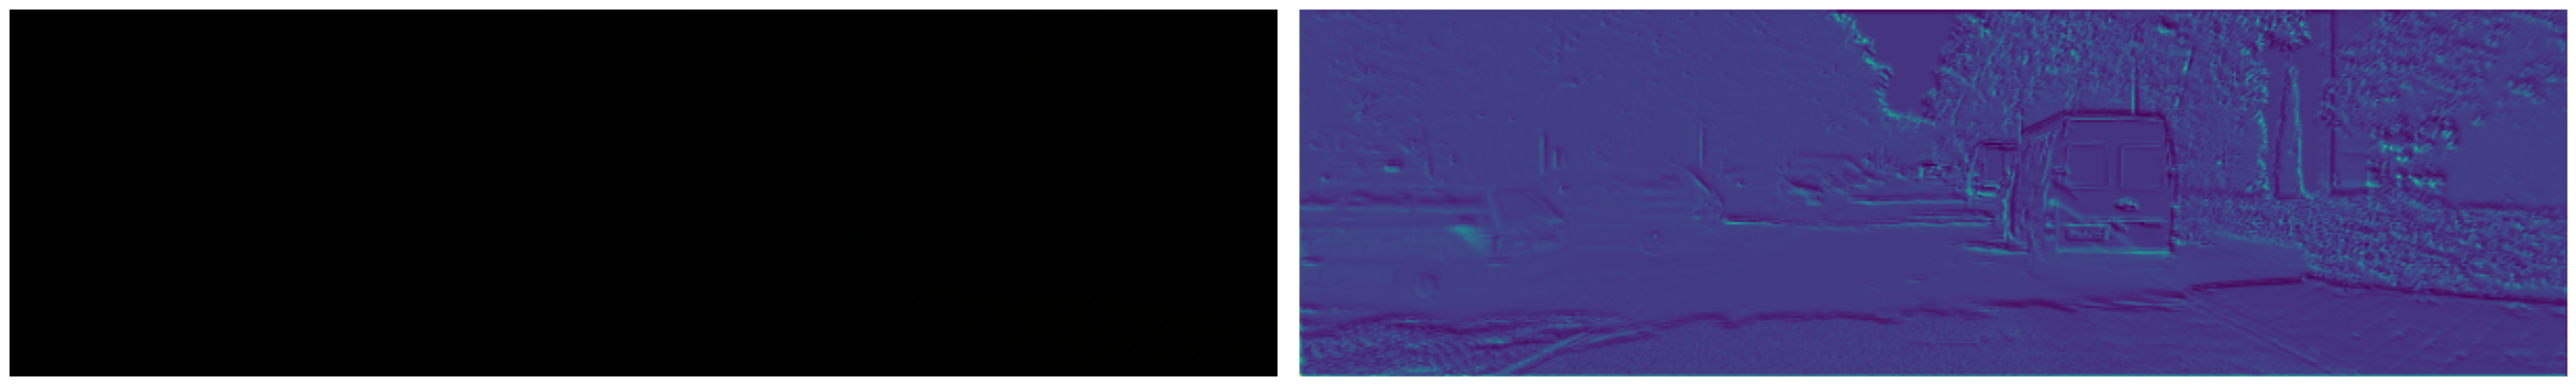

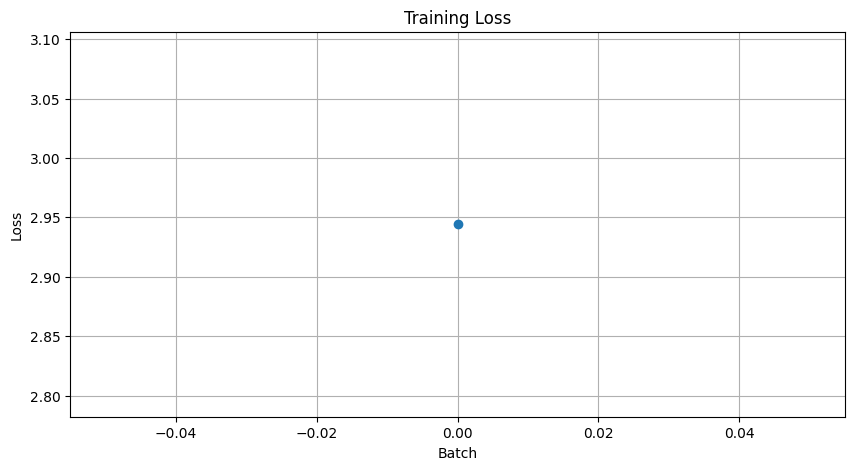

Epoch 1/10:   2%|▏         | 2/85 [00:01<00:56,  1.46it/s]

loss: 3.1146223545074463


Epoch 1/10:   4%|▎         | 3/85 [00:01<00:41,  1.99it/s]

loss: 2.634784698486328


Epoch 1/10:   5%|▍         | 4/85 [00:02<00:35,  2.30it/s]

loss: 2.722052574157715


Epoch 1/10:   6%|▌         | 5/85 [00:02<00:31,  2.56it/s]

loss: 2.7603957653045654
loss: 3.03625750541687


<Figure size 1750x500 with 0 Axes>

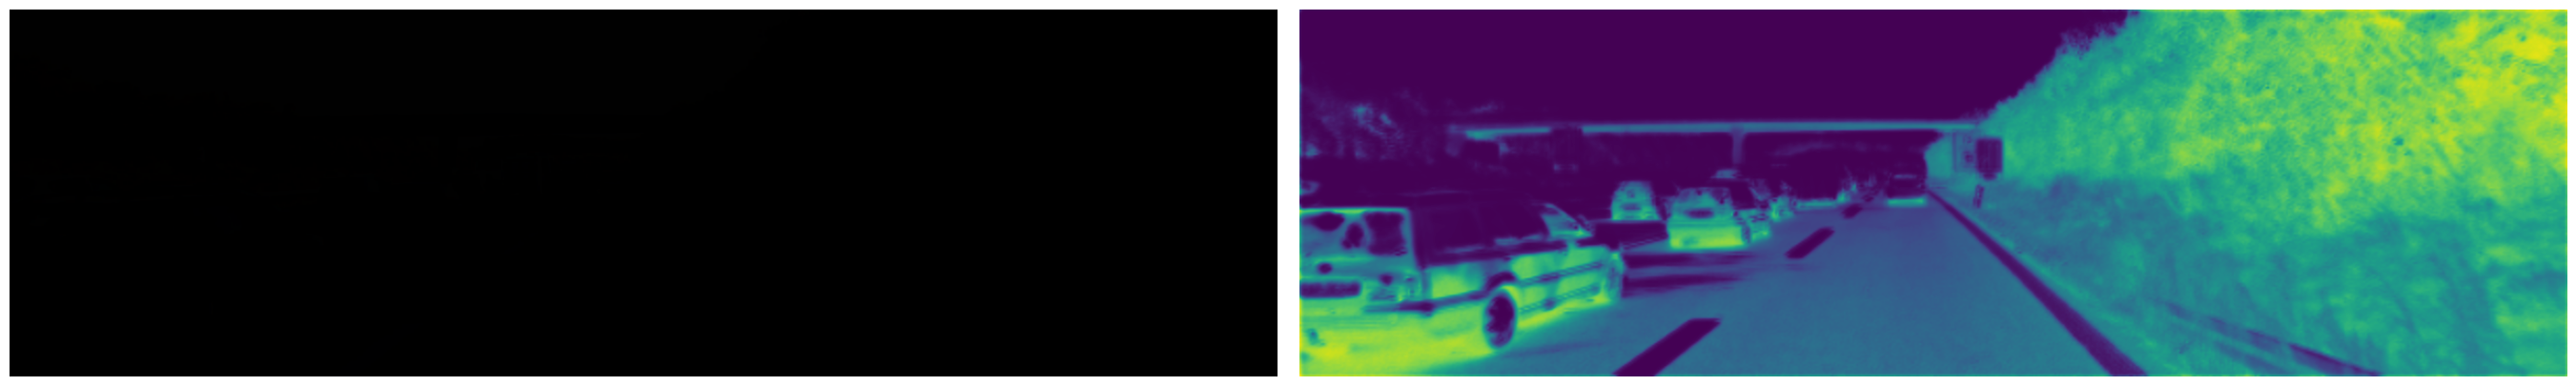

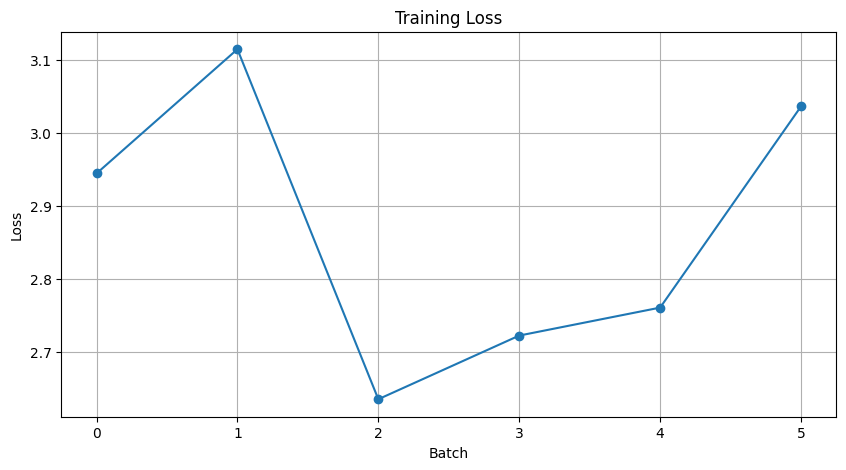

Epoch 1/10:   8%|▊         | 7/85 [00:03<00:38,  2.03it/s]

loss: 2.8940067291259766


Epoch 1/10:   9%|▉         | 8/85 [00:04<00:33,  2.32it/s]

loss: 2.8993682861328125


Epoch 1/10:  11%|█         | 9/85 [00:04<00:32,  2.33it/s]

loss: 2.012054443359375


Epoch 1/10:  12%|█▏        | 10/85 [00:04<00:30,  2.49it/s]

loss: 2.5222713947296143
loss: 2.5826210975646973


<Figure size 1750x500 with 0 Axes>

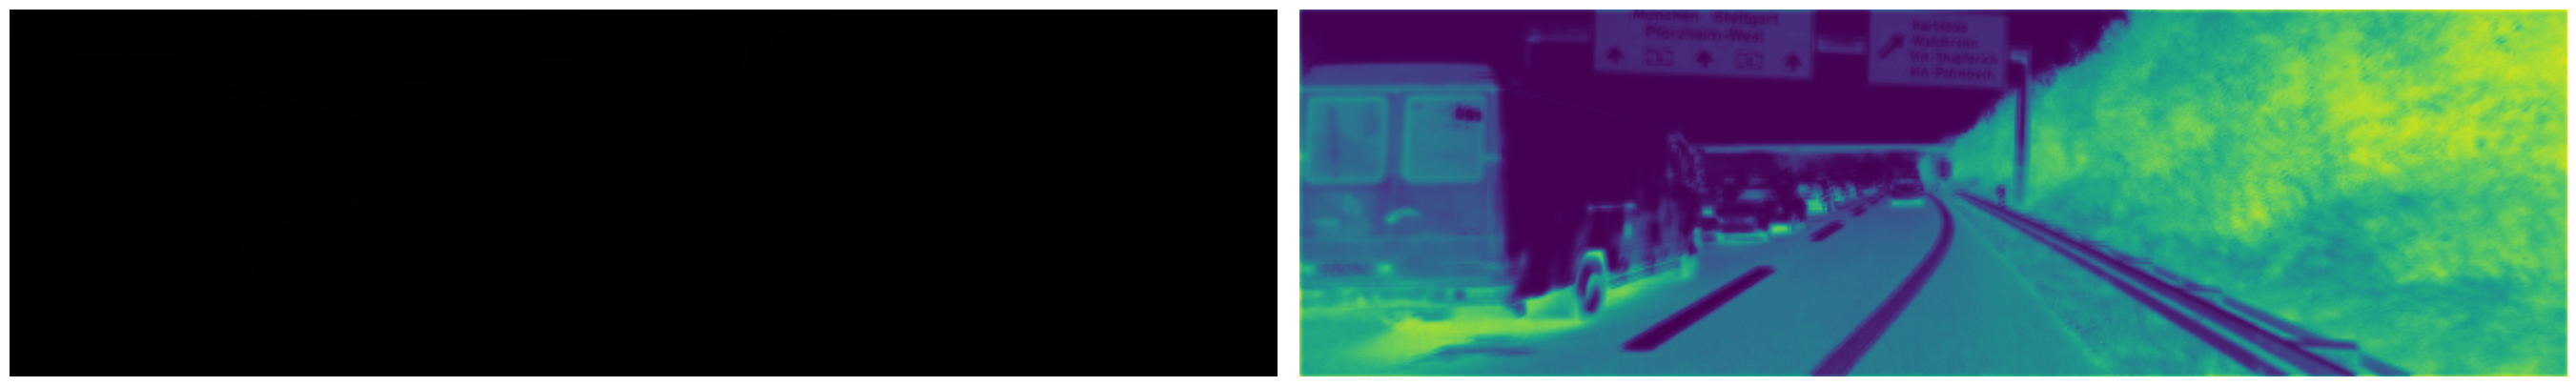

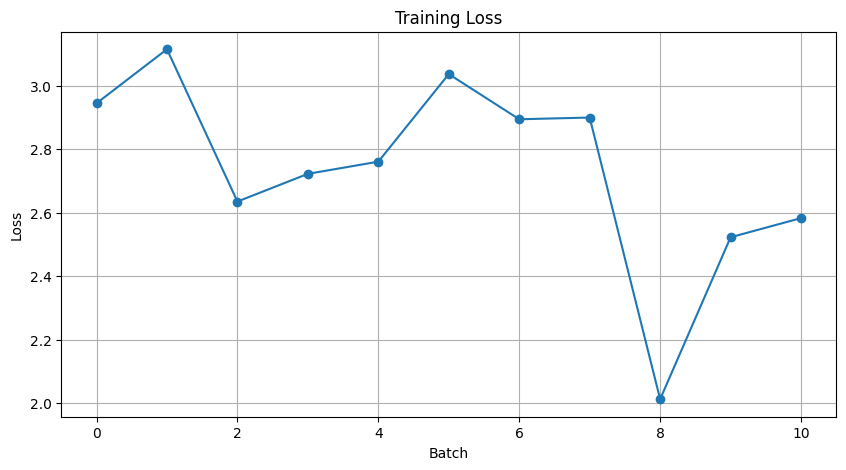

Epoch 1/10:  14%|█▍        | 12/85 [00:06<00:35,  2.04it/s]

loss: 2.7076103687286377


Epoch 1/10:  15%|█▌        | 13/85 [00:06<00:32,  2.25it/s]

loss: 2.7056732177734375


Epoch 1/10:  16%|█▋        | 14/85 [00:06<00:30,  2.32it/s]

loss: 2.9370315074920654


Epoch 1/10:  18%|█▊        | 15/85 [00:07<00:28,  2.48it/s]

loss: 2.433596611022949
loss: 2.3519492149353027


<Figure size 1750x500 with 0 Axes>

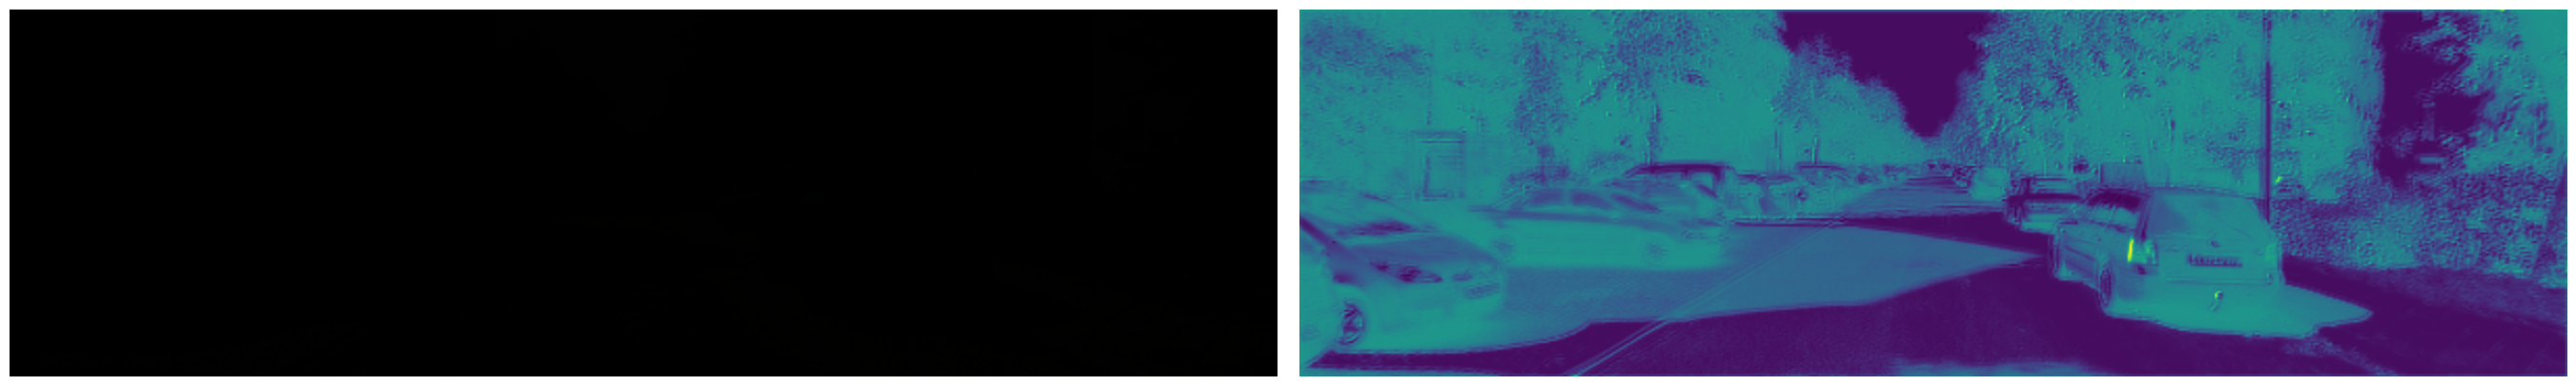

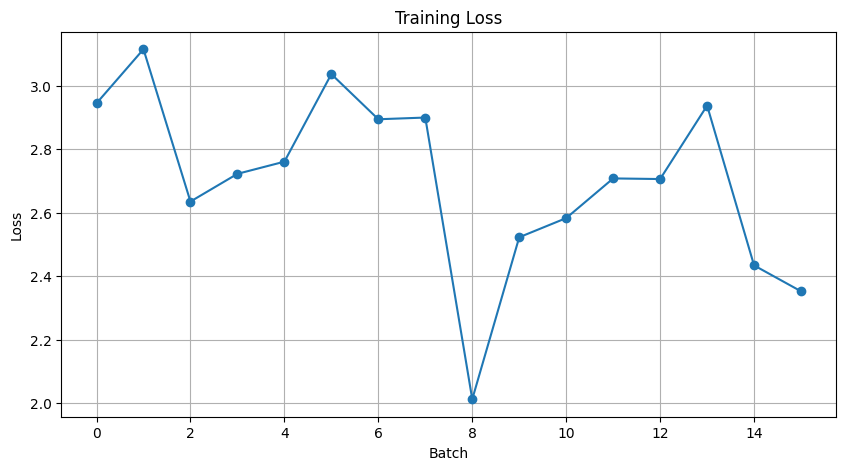

Epoch 1/10:  20%|██        | 17/85 [00:08<00:35,  1.93it/s]

loss: 2.936957359313965


Epoch 1/10:  21%|██        | 18/85 [00:08<00:30,  2.17it/s]

loss: 2.7868850231170654


Epoch 1/10:  22%|██▏       | 19/85 [00:09<00:28,  2.30it/s]

loss: 2.786921501159668


Epoch 1/10:  24%|██▎       | 20/85 [00:09<00:27,  2.35it/s]

loss: 2.6229052543640137
loss: 2.8780899047851562


<Figure size 1750x500 with 0 Axes>

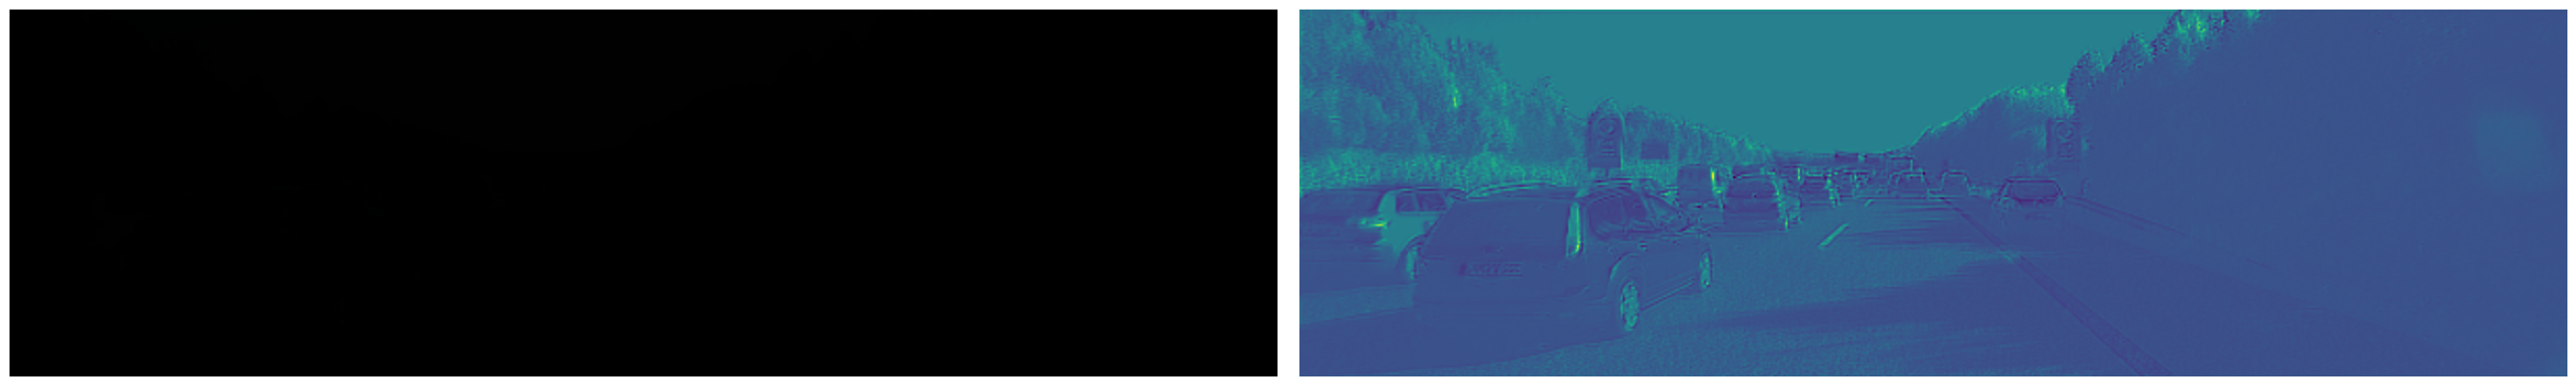

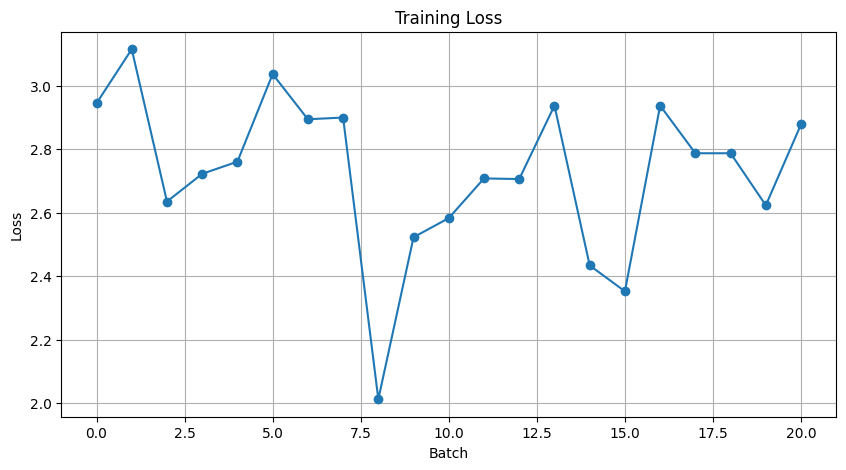

Epoch 1/10:  26%|██▌       | 22/85 [00:10<00:33,  1.90it/s]

loss: 3.1728508472442627


Epoch 1/10:  27%|██▋       | 23/85 [00:11<00:29,  2.14it/s]

loss: 2.5570967197418213


Epoch 1/10:  28%|██▊       | 24/85 [00:11<00:27,  2.25it/s]

loss: 2.2864599227905273


Epoch 1/10:  29%|██▉       | 25/85 [00:12<00:25,  2.32it/s]

loss: 2.7660329341888428
loss: 2.5499930381774902


<Figure size 1750x500 with 0 Axes>

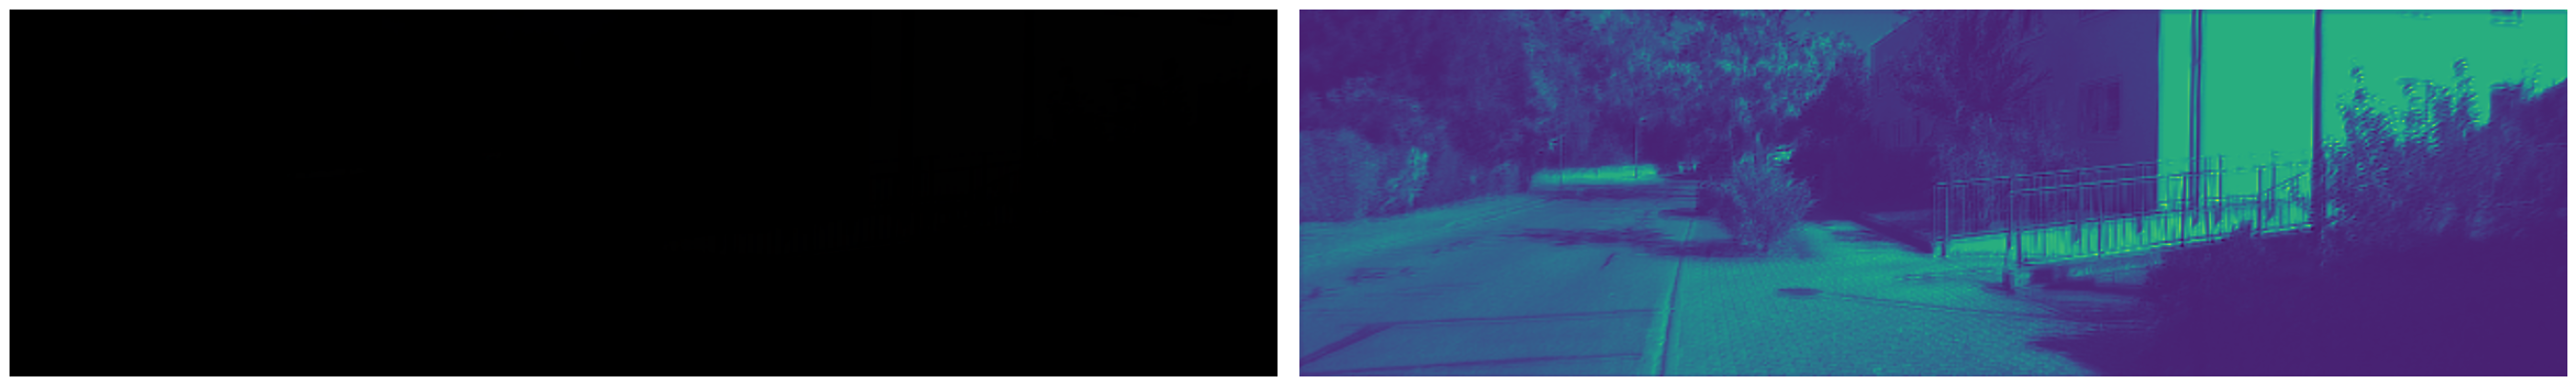

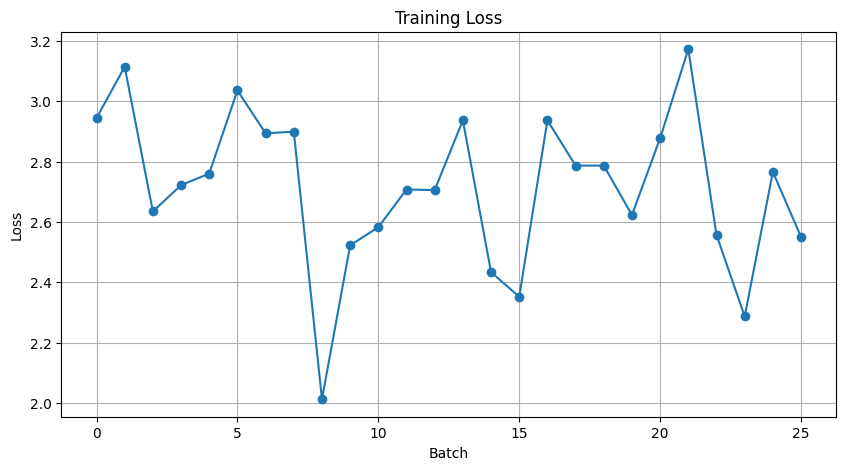

Epoch 1/10:  32%|███▏      | 27/85 [00:13<00:32,  1.81it/s]

loss: 2.2343854904174805


Epoch 1/10:  33%|███▎      | 28/85 [00:13<00:28,  1.99it/s]

loss: 2.516012668609619


Epoch 1/10:  34%|███▍      | 29/85 [00:14<00:26,  2.10it/s]

loss: 2.5266053676605225


Epoch 1/10:  35%|███▌      | 30/85 [00:14<00:25,  2.15it/s]

loss: 2.617737054824829
loss: 2.663954734802246


<Figure size 1750x500 with 0 Axes>

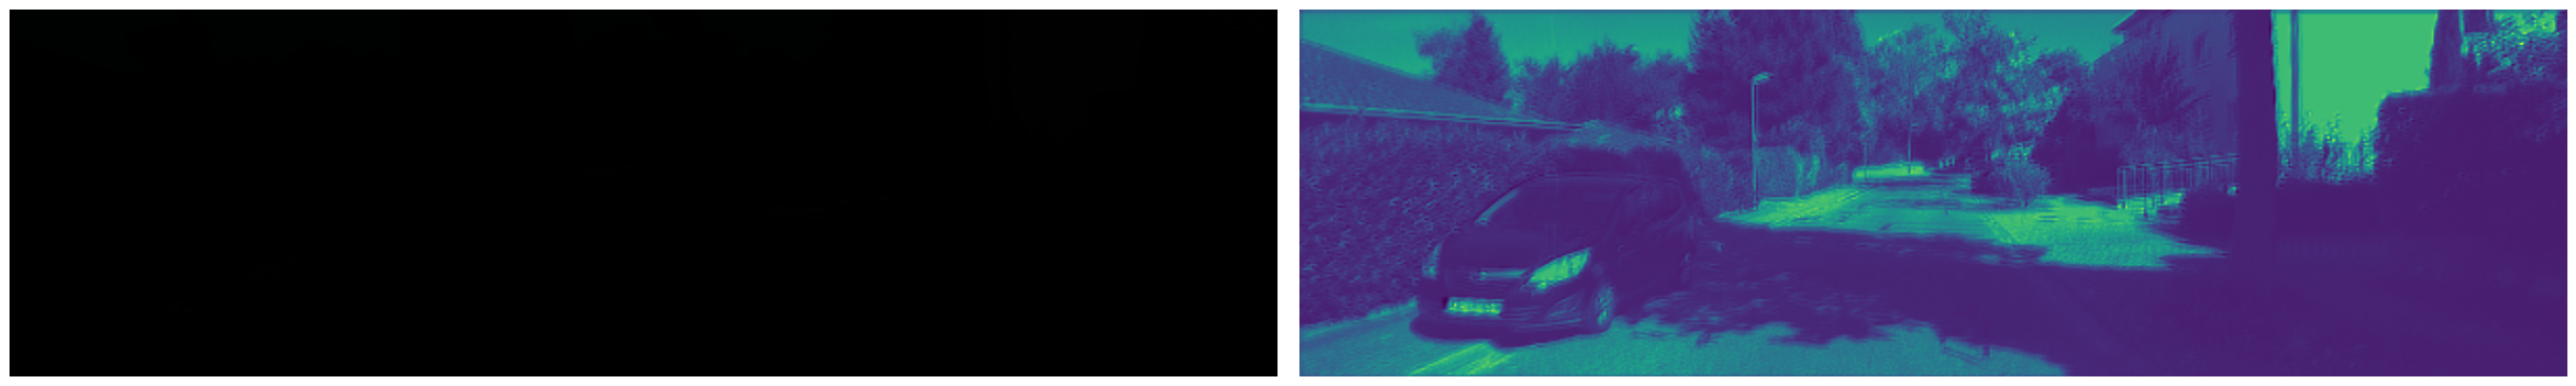

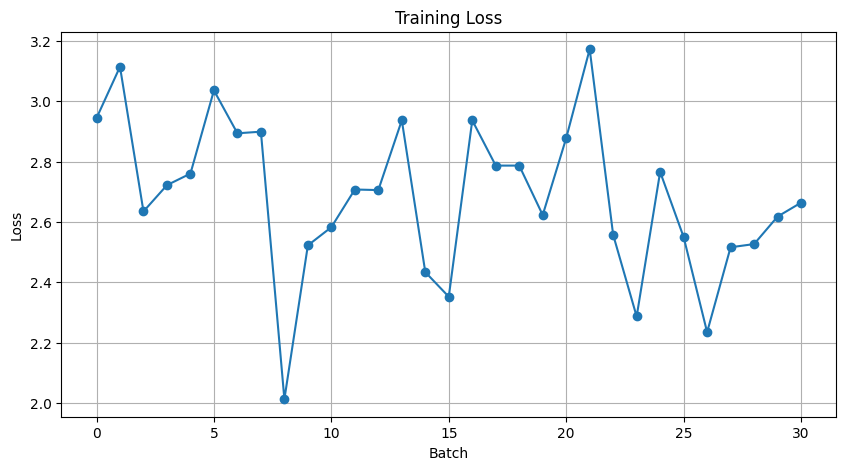

Epoch 1/10:  38%|███▊      | 32/85 [00:16<00:29,  1.78it/s]

loss: 2.296260356903076


Epoch 1/10:  39%|███▉      | 33/85 [00:16<00:28,  1.85it/s]

loss: 2.4253089427948


Epoch 1/10:  40%|████      | 34/85 [00:16<00:25,  2.03it/s]

loss: 2.7917895317077637


Epoch 1/10:  41%|████      | 35/85 [00:17<00:23,  2.16it/s]

loss: 2.691225290298462
loss: 3.1270081996917725


<Figure size 1750x500 with 0 Axes>

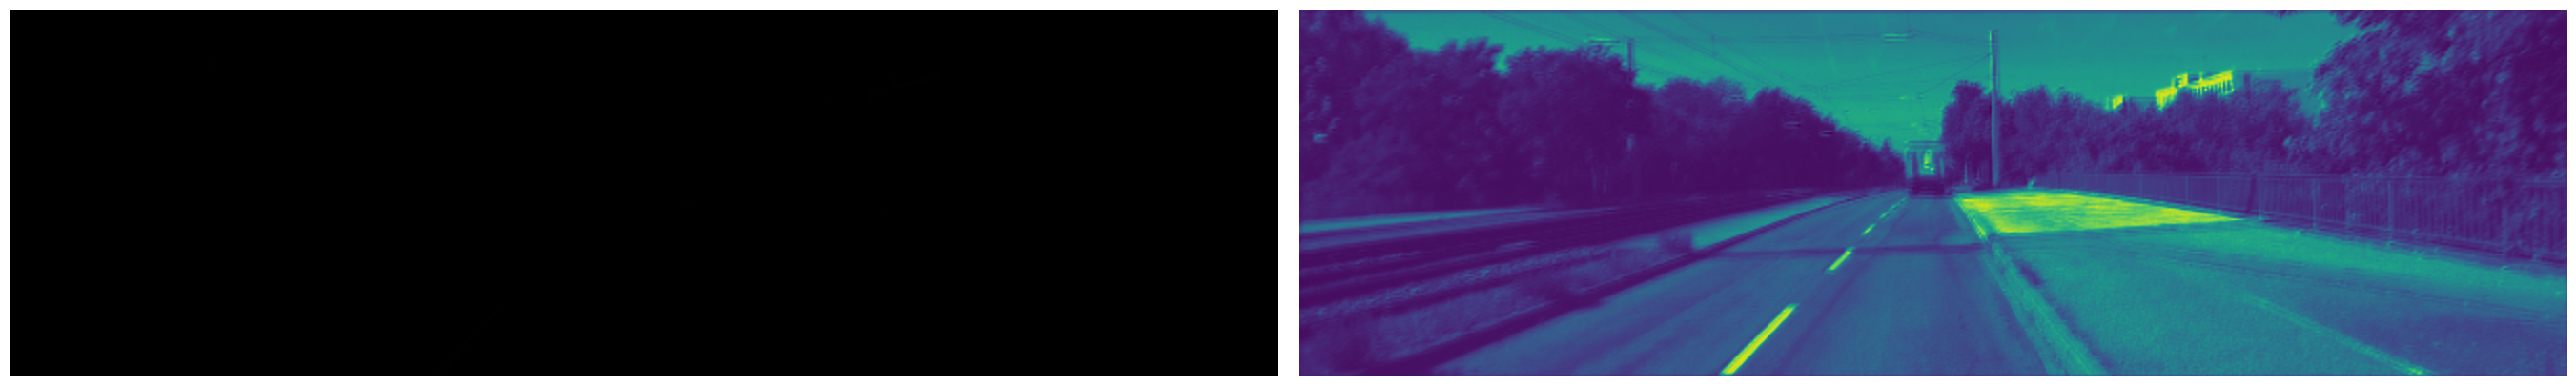

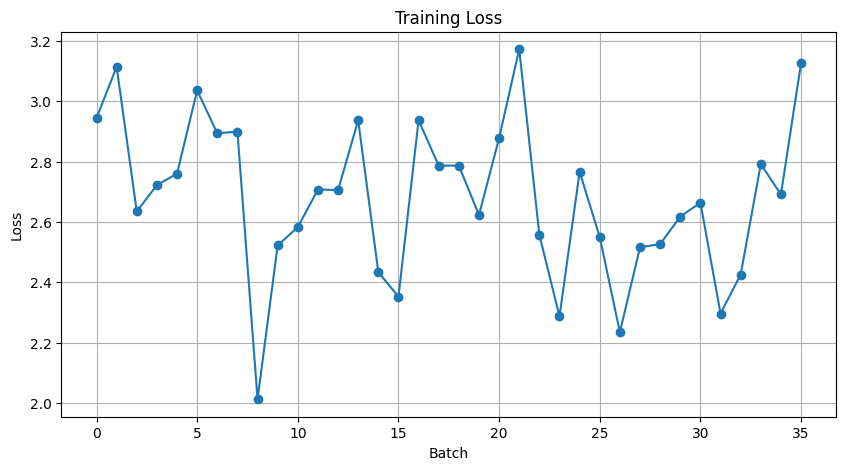

Epoch 1/10:  44%|████▎     | 37/85 [00:18<00:26,  1.84it/s]

loss: 2.5392556190490723


Epoch 1/10:  45%|████▍     | 38/85 [00:19<00:22,  2.08it/s]

loss: 2.6962931156158447


Epoch 1/10:  46%|████▌     | 39/85 [00:19<00:21,  2.17it/s]

loss: 2.9594082832336426


Epoch 1/10:  47%|████▋     | 40/85 [00:19<00:19,  2.30it/s]

loss: 3.038843870162964
loss: 2.554034948348999


<Figure size 1750x500 with 0 Axes>

Epoch 1/10:  47%|████▋     | 40/85 [00:20<00:23,  1.95it/s]


KeyboardInterrupt: 

In [34]:
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

def train(model, train_loader, criterion, optimizer, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        losses = []
        batch = 0
        for images, depth_maps in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            optimizer.zero_grad()
            pred_depth_maps = model(images.to(device))
            # print(f"Shape of depth map: {depth_maps.shape}")
            loss = criterion(pred_depth_maps, depth_maps.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"loss: {loss.item()}")
            losses.append(loss.cpu().detach().numpy())
            if batch % 10 == 0 and batch != 0:
                # print(f"Shape of images[0]: {images[0].shape}")
                visualize_images([images[0].cpu().detach().numpy(), pred_depth_maps[0].cpu().detach().numpy()], png=False)
                visualize_losses(losses)
            scheduler.step()
            batch += 1
                

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss}")

# # Usage example:
# model = DenseNetAutoencoder()
# input_tensor = torch.randn(1, 3, 480, 640)  # Example input shape (batch_size, channels, height, width)
# output = model(input_tensor)

# remove 8 layers to get a latent space that is half of the size of the input
autoencoder = ResNet18Autoencoder(remove=8, pretrained=True)

criterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(autoencoder, trainloader, criterion, optimizer, epochs=10)
evaluate(autoencoder, valloader, criterion)
# TypeError: Invalid shape (352, 1216, 64) for image data

C:\Users\Sam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/85 [00:00<?, ?it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:   1%|          | 1/85 [00:00<00:42,  1.97it/s]

loss: 0.7657508254051208
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.44188833236694336
0


Epoch 1/10:   4%|▎         | 3/85 [00:00<00:21,  3.75it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.39734429121017456
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:   5%|▍         | 4/85 [00:01<00:18,  4.27it/s]

loss: 0.3601016402244568
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.38183659315109253
0


Epoch 1/10:   7%|▋         | 6/85 [00:01<00:16,  4.85it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.3448029160499573
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:   8%|▊         | 7/85 [00:01<00:15,  5.06it/s]

loss: 0.32697349786758423
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.36014968156814575
0


Epoch 1/10:  11%|█         | 9/85 [00:02<00:15,  5.02it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.32339543104171753
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:  12%|█▏        | 10/85 [00:02<00:14,  5.11it/s]

loss: 0.30206939578056335
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:  13%|█▎        | 11/85 [00:02<00:15,  4.64it/s]

loss: 0.29089078307151794
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.25929492712020874
0


Epoch 1/10:  15%|█▌        | 13/85 [00:02<00:15,  4.79it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.2607850730419159
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:  16%|█▋        | 14/85 [00:03<00:14,  4.89it/s]

loss: 0.23187455534934998
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.21518196165561676
0


Epoch 1/10:  19%|█▉        | 16/85 [00:03<00:13,  4.95it/s]

Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.19689953327178955
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])


Epoch 1/10:  20%|██        | 17/85 [00:03<00:13,  5.06it/s]

loss: 0.16734381020069122
0
Shape of input: torch.Size([8, 3, 352, 1216])
Shape of latent representation: torch.Size([8, 64, 176, 608])
Shape after decoding: torch.Size([8, 1, 352, 1216])
Shape of depth map: torch.Size([8, 1, 352, 1216])
loss: 0.15305384993553162
0


Epoch 1/10:  21%|██        | 18/85 [00:03<00:14,  4.53it/s]


KeyboardInterrupt: 

# Reduce Dimensionality with LLE
1 512
2 214016
3 428032

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
#Hyperparamaters!
n_components = 150
n_neighbors = 25
lle = LocallyLinearEmbedding(n_components = n_components, n_neighbors = n_neighbors, method='standard')
features_lle = lle.fit_transform(features)
features.shape, features_lle.shape

(torch.Size([680, 512]), (680, 150))